DEBUG:poppy:Trans: None
DEBUG:poppy:OPD: wfe_on_axis.fits
DEBUG:poppy:No transmission supplied - will assume uniform throughput = 1 
INFO:poppy:OPD from wfe_on_axis.fits: Loaded OPD from wfe_on_axis.fits
INFO:poppy:No info supplied on amplitude transmission; assuming uniform throughput = 1
DEBUG:poppy:  Getting pixel scale from user-provided float value: 9.960937499999999e-06


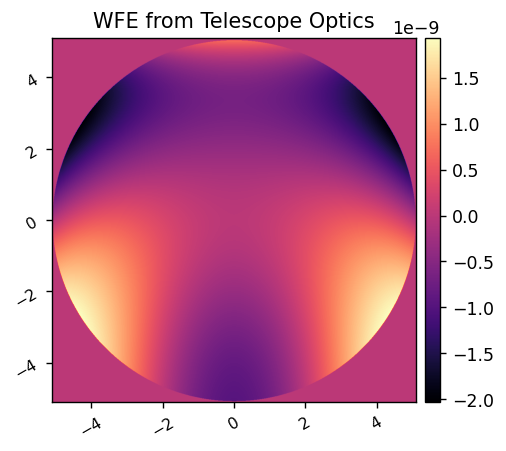

In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
xp = cp if poppy.accel_math._USE_CUPY else np

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import full, agpm
reload(full)

from wfsc_1dm import utils

from imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 750e-9*u.m

reload(agpm)
vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm/2, gray_pixel=False)

hdr = fits.getheader('wfe_on_axis.fits')
ote_wfe = poppy.FITSOpticalElement(opd='wfe_on_axis.fits', opdunits='meters',
                                   pixelscale=pupil_diam.to_value(u.m)/hdr['NAXIS1'])
imshow1(ote_wfe.opd, 'WFE from Telescope Optics', pxscl=ote_wfe.pixelscale.to(u.mm/u.pix))

def ensure_np_array(arr):
    if isinstance(arr, np.ndarray):
        return arr
    else:
        return arr.get()

In [2]:
reload(full)
c = full.CORO()

INFO:poppy:Loaded influence function from inf.fits for DM
DEBUG:poppy:Initialized: OAP1, fl =2.00e-01 m
DEBUG:poppy:Initialized: OAP2, fl =2.00e-01 m
DEBUG:poppy:Initialized: OAP3, fl =5.00e-01 m
DEBUG:poppy:Initialized: OAP4, fl =3.50e-01 m
DEBUG:poppy:Initialized: OAP5, fl =2.00e-01 m
INFO:poppy:Initialized OpticalSystem: unnamed system
INFO:poppy:Added optic: Circle, radius=5.1 mm after separation: 0.00e+00 m 
INFO:poppy:Added optic: OTE WFE Place-holder after separation: 0.00e+00 m 
INFO:poppy:Added optic: DM after separation: 0.00e+00 m 
INFO:poppy:Added optic: OAP1 after separation: 2.00e+02 mm 
INFO:poppy:Added optic: Circle, radius=6.35 mm after separation: 0.00e+00 m 
INFO:poppy:Added optic: Int Focal Plane after separation: 2.00e+02 mm 
INFO:poppy:Added optic: OAP2 after separation: 2.00e+02 mm 
INFO:poppy:Added optic: Circle, radius=6.35 mm after separation: 0.00e+00 m 
INFO:poppy:Added optic: Apodizer Place-holder after separation: 2.00e+02 mm 
INFO:poppy:Added optic: OAP3 

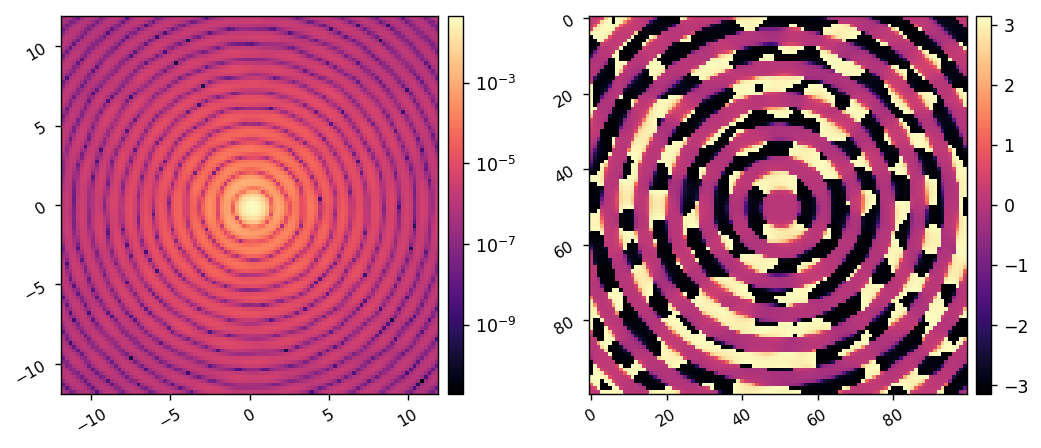

In [4]:
reload(full)
poppy_log.disabled = True

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

c = full.CORO()

c.npix = 128
c.oversample = 16

c.use_opds = True
c.OTEWFE = ote_wfe

psf = c.calc_psf()
imshow2(np.abs(psf)**2, np.angle(psf),
             pxscl1=c.psf_pixelscale_lamD, lognorm1=True)



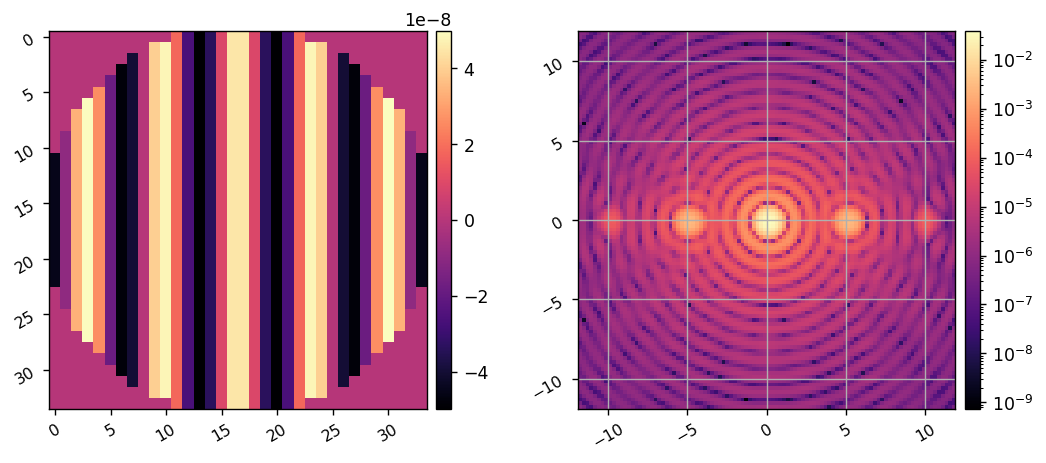

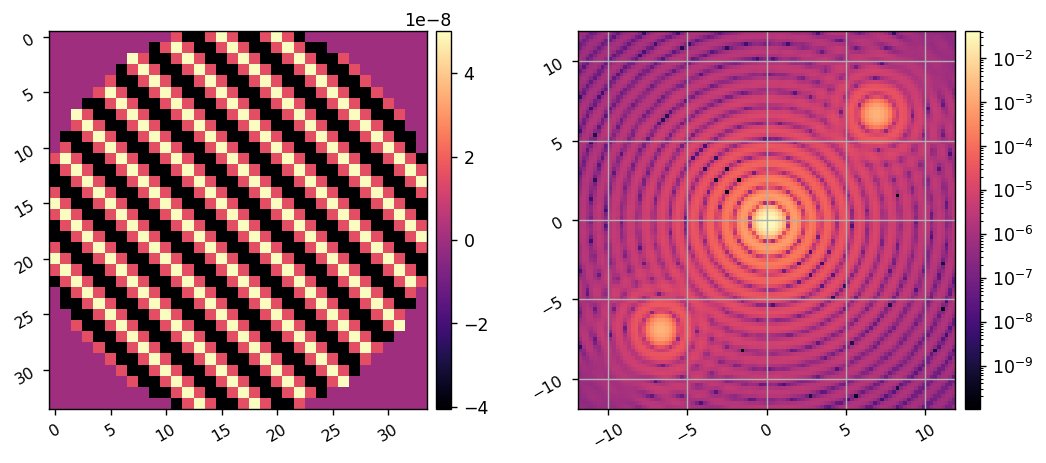

In [5]:
poppy_log.disabled = True

reload(full)
c = full.CORO()

Nact = c.Nact

xpp = np.linspace(-c.Nact/2, c.Nact/2-1, c.Nact) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

separation = 5

amp = 5e-8
com_1 = amp*np.cos(2*np.pi*ppx*separation/Nact)*c.dm_mask
com_2 = amp*np.cos(2*np.pi*(ppx - ppy)/separation)*c.dm_mask

c.set_dm(com_1)
im1 = c.snap()
imshow2(c.get_dm(), im1, pxscl2=c.psf_pixelscale_lamD, lognorm2=True, grid2=True)

c.set_dm(com_2)
im2 = c.snap()
imshow2(c.get_dm(), im2, pxscl2=c.psf_pixelscale_lamD, lognorm2=True, grid2=True)

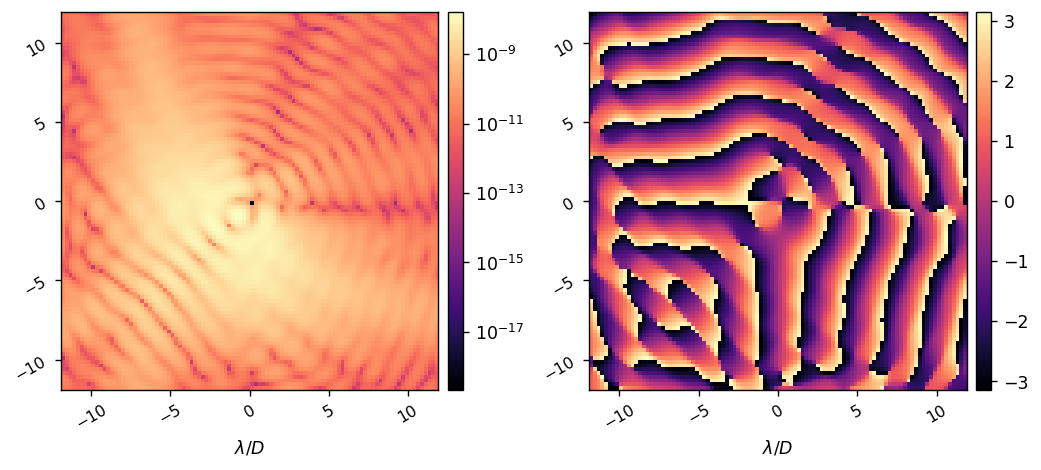

In [7]:
poppy_log.disabled = True

c.reset_dm()

c.FPM = vortex
c.LYOT = lyot_stop
occ_psf = c.calc_psf()

imshow2(np.abs(occ_psf)**2, np.angle(occ_psf),
             pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$',
             lognorm1=True)



Propagating wavelength 750.000 nm.
PSF calculated in 0.785s


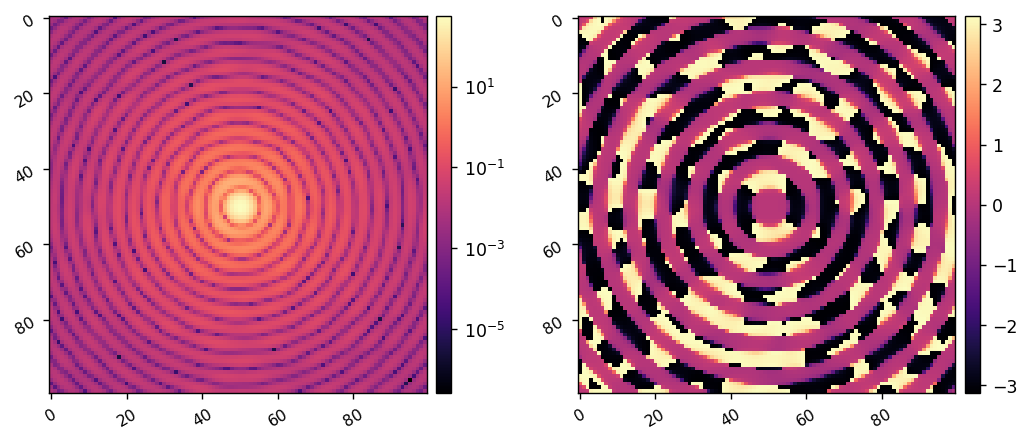

In [8]:
poppy_log.disabled = True

reload(full)
c = full.CORO()

c.norm = 'none'

c.npix = 128
c.oversample = 16

c.use_opds = True
c.OTEWFE = ote_wfe

c.APODIZER = None

c.FPM = None
c.LYOT = None

# c.FPM = vortex
# c.LYOT = lyot_stop

wfs = c.calc_wfs()

imshow2(wfs[-1].intensity, wfs[-1].phase, lognorm1=True)

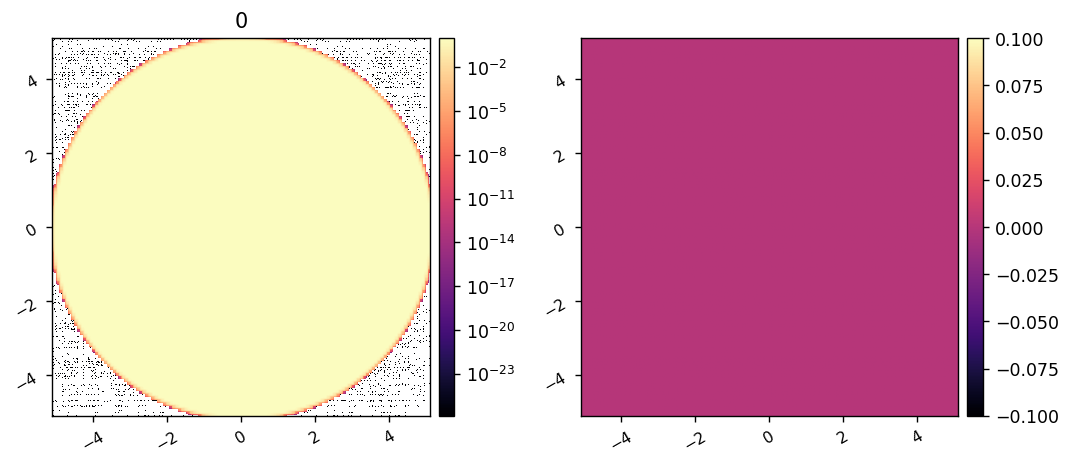

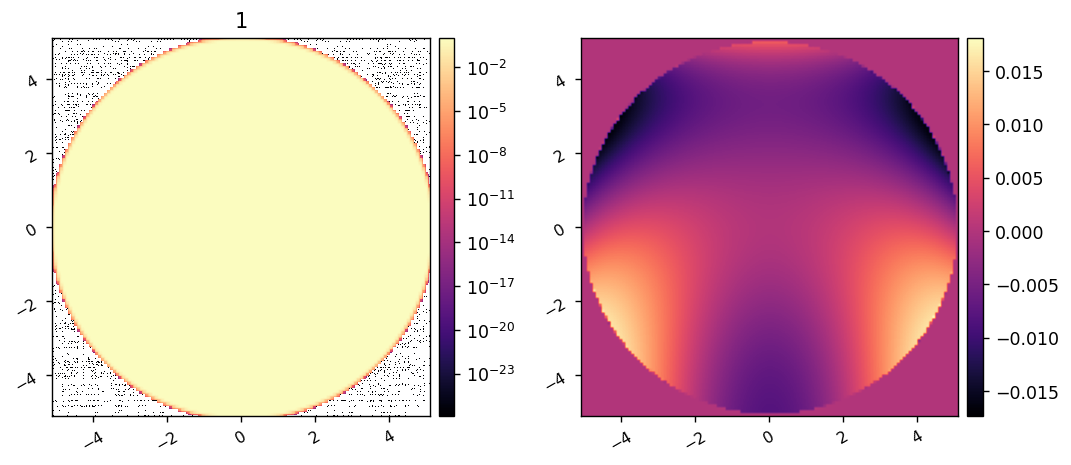

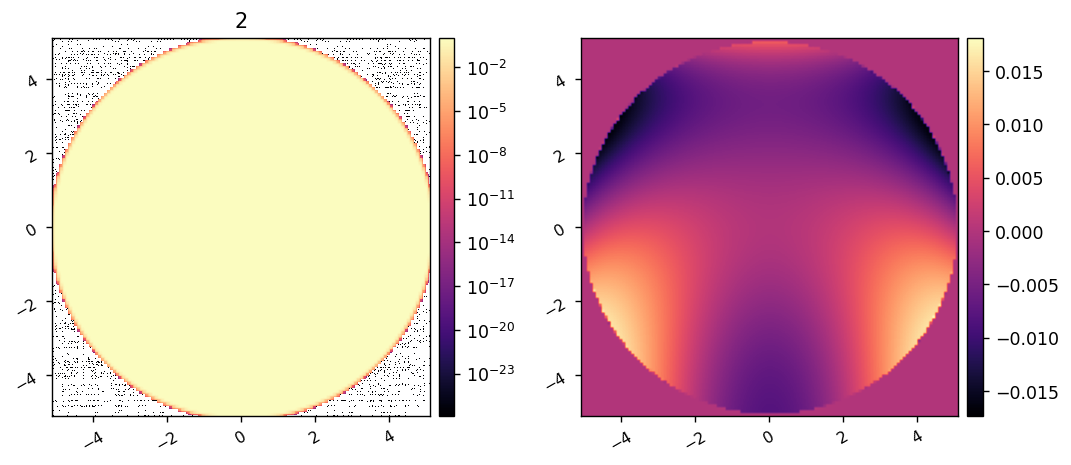

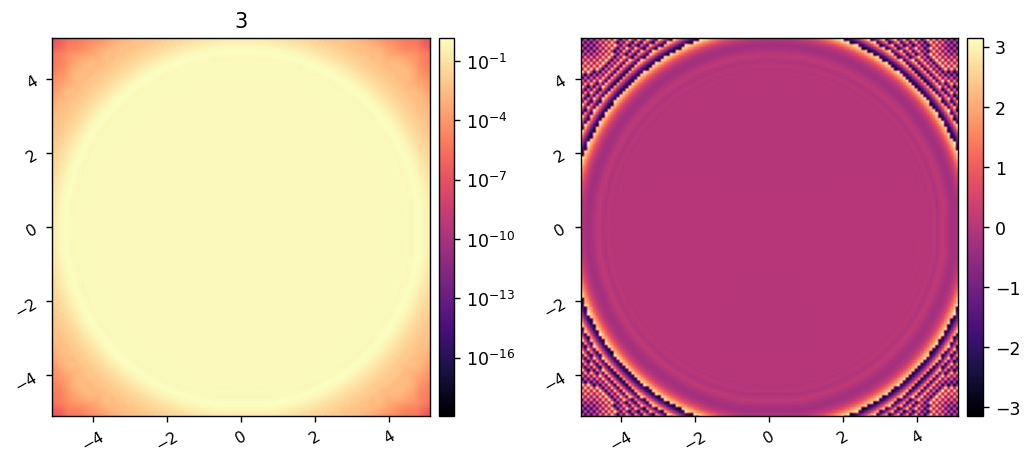

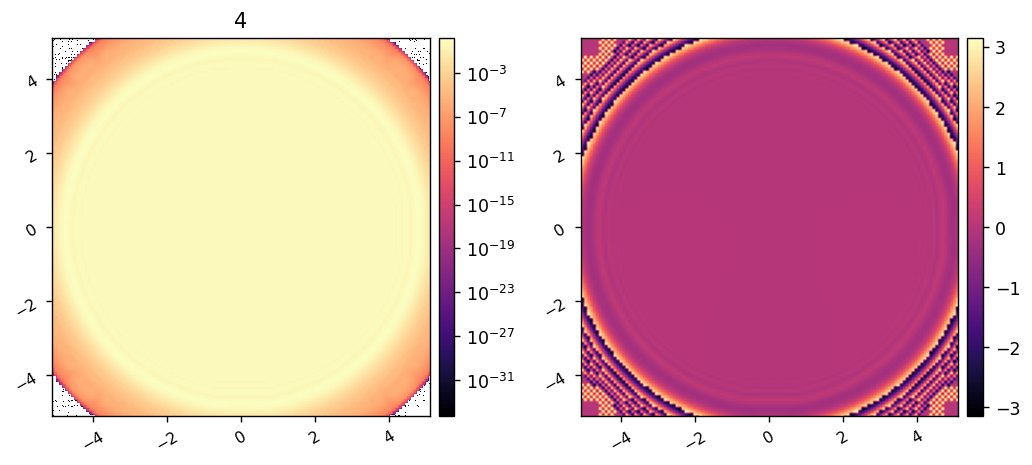

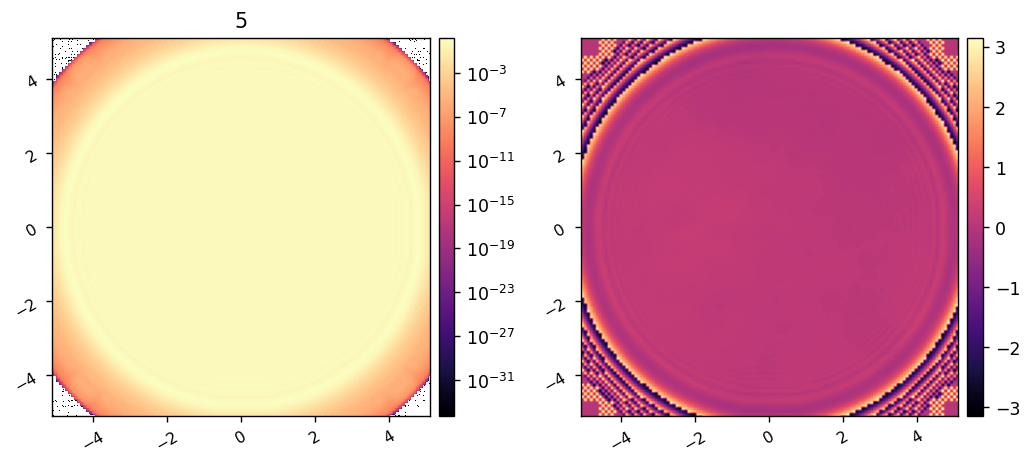

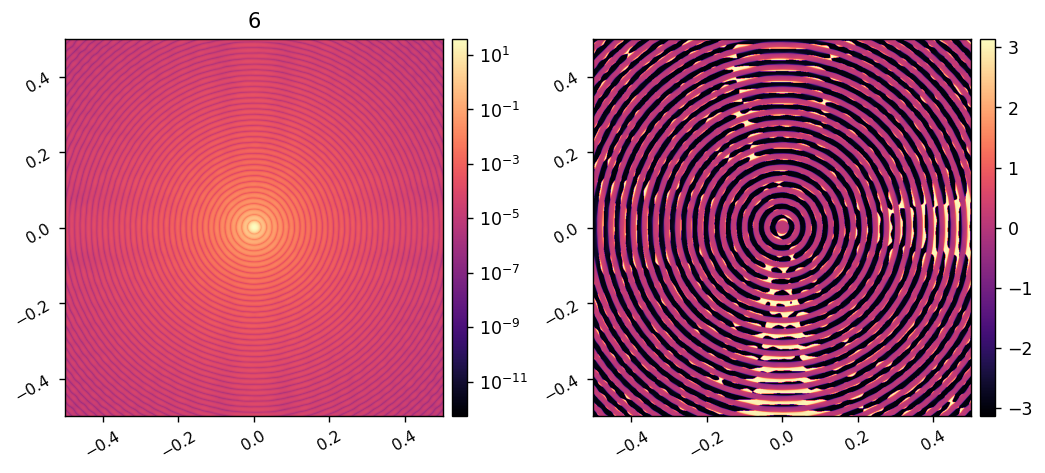

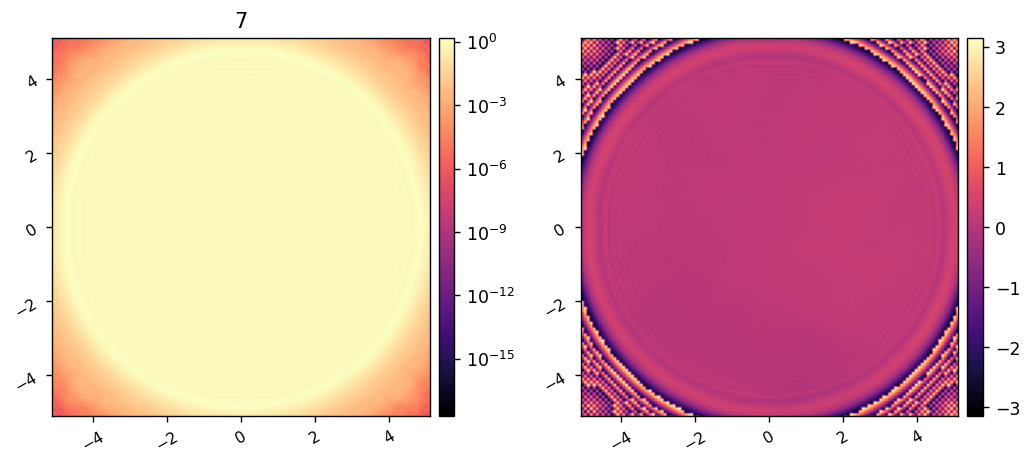

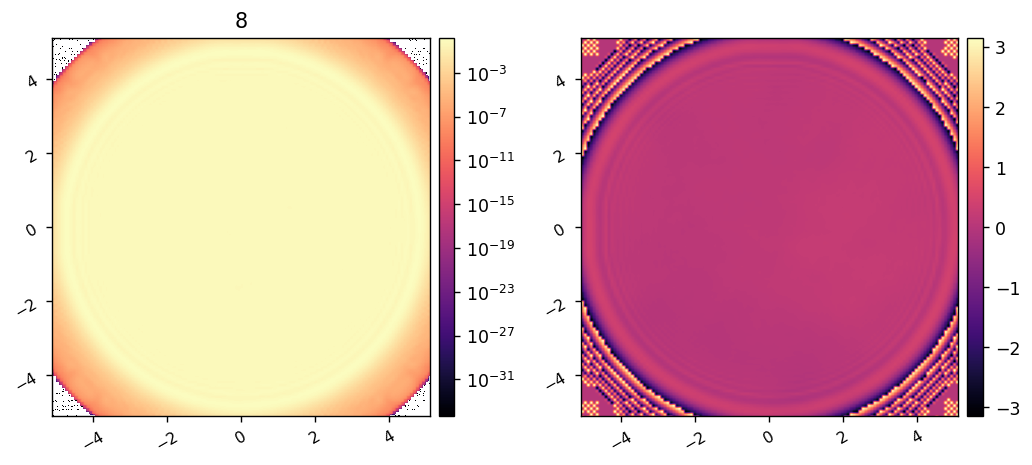

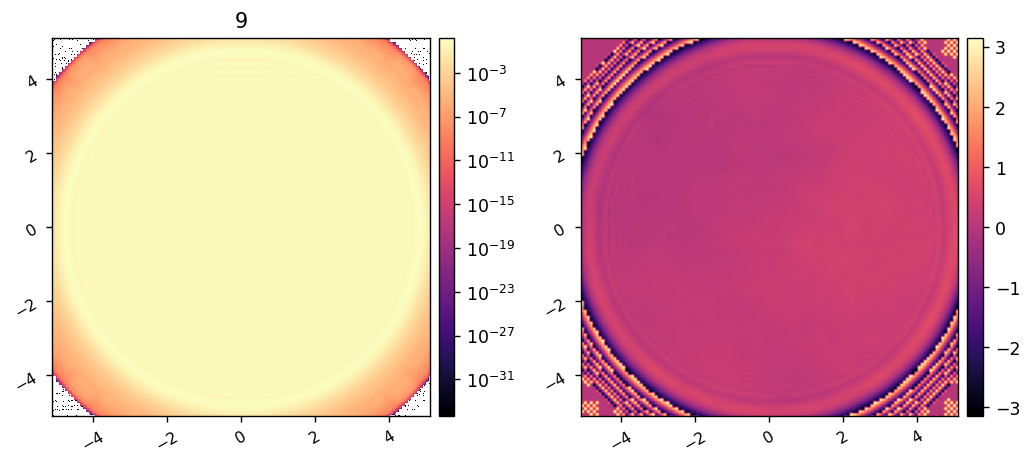

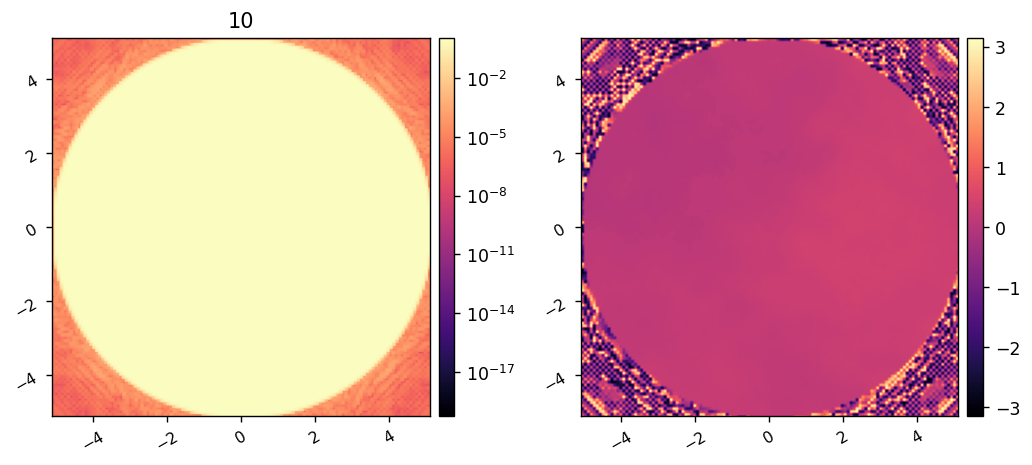

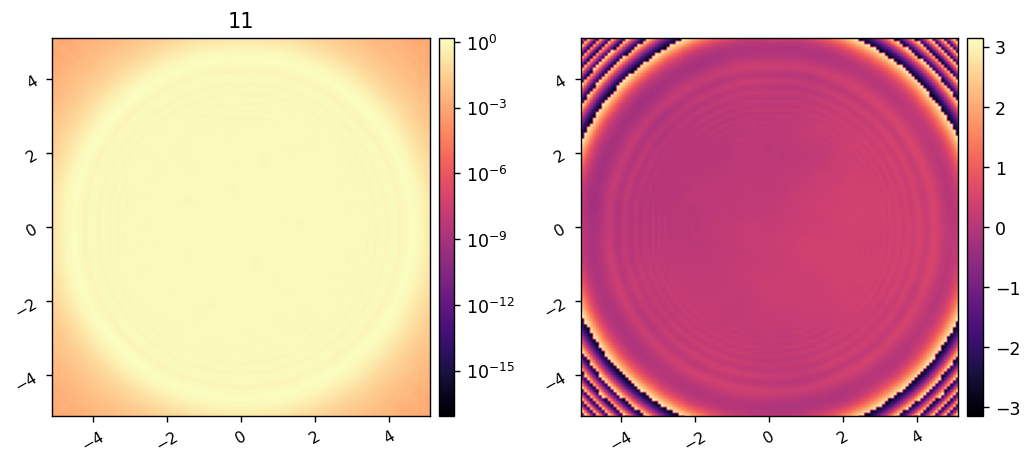

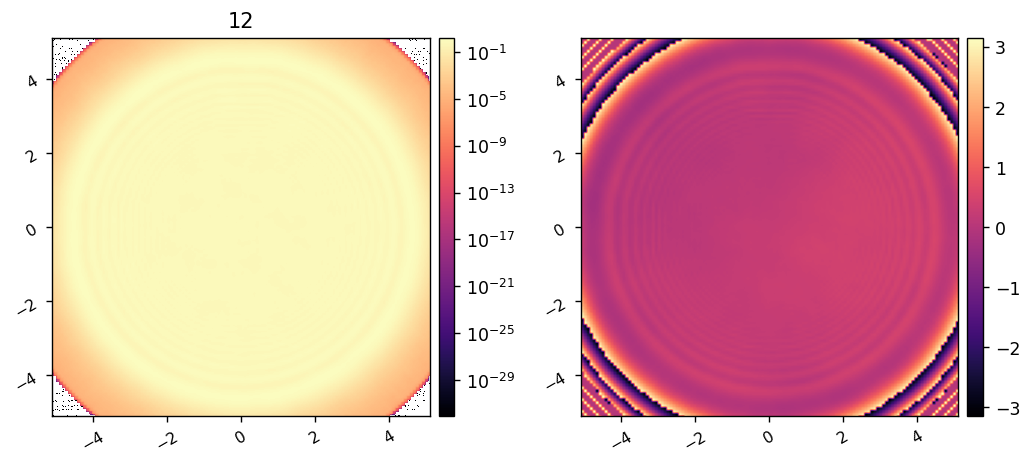

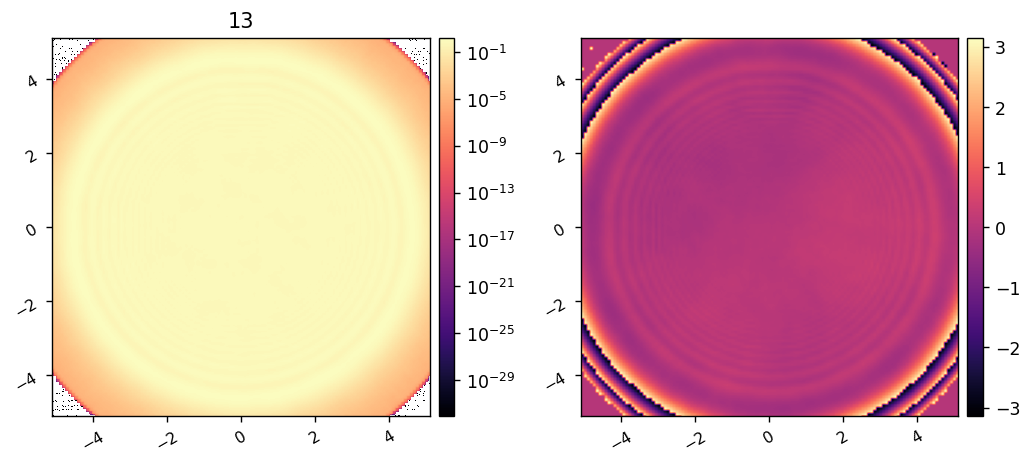

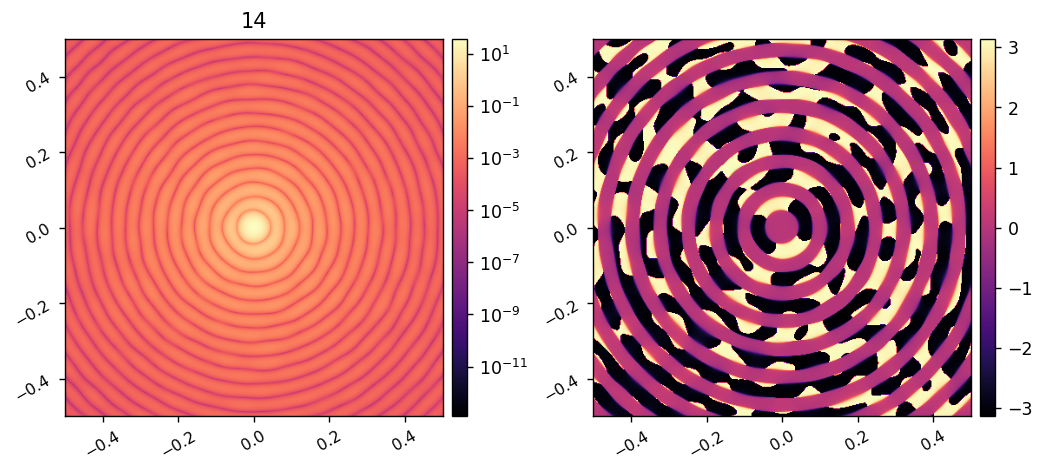

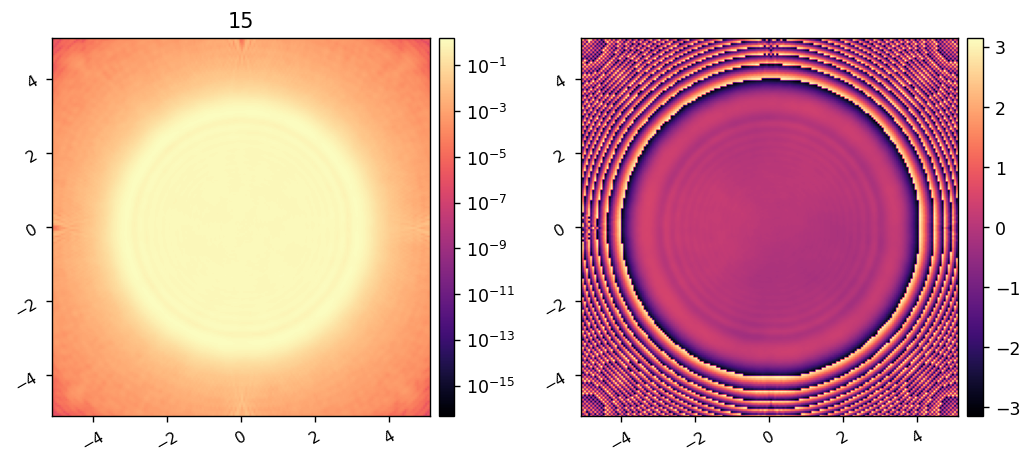

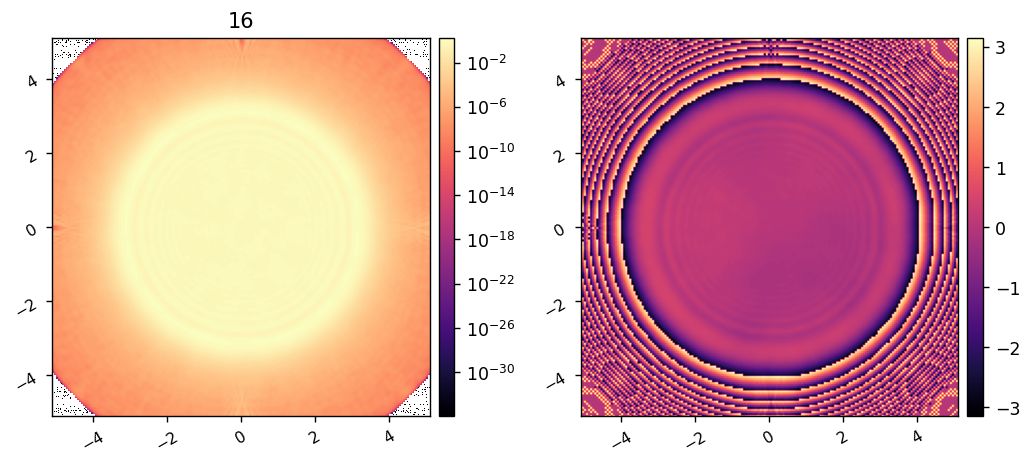

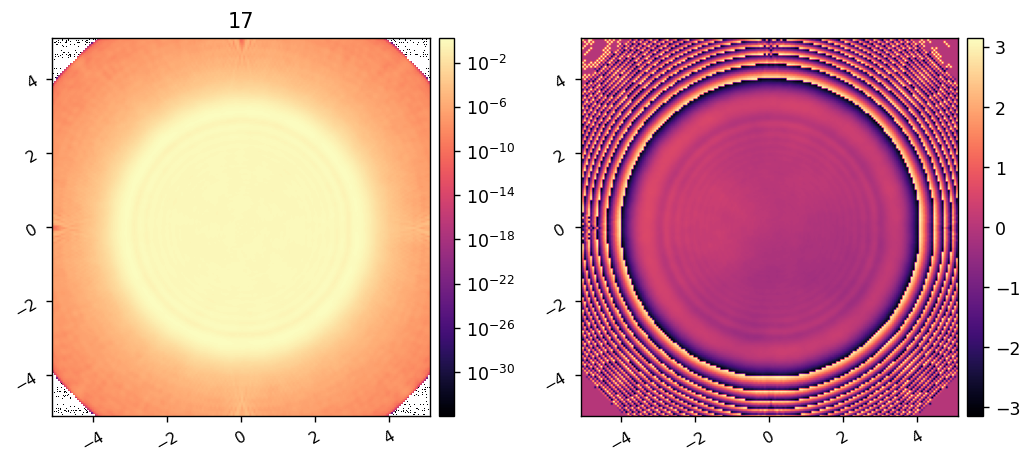

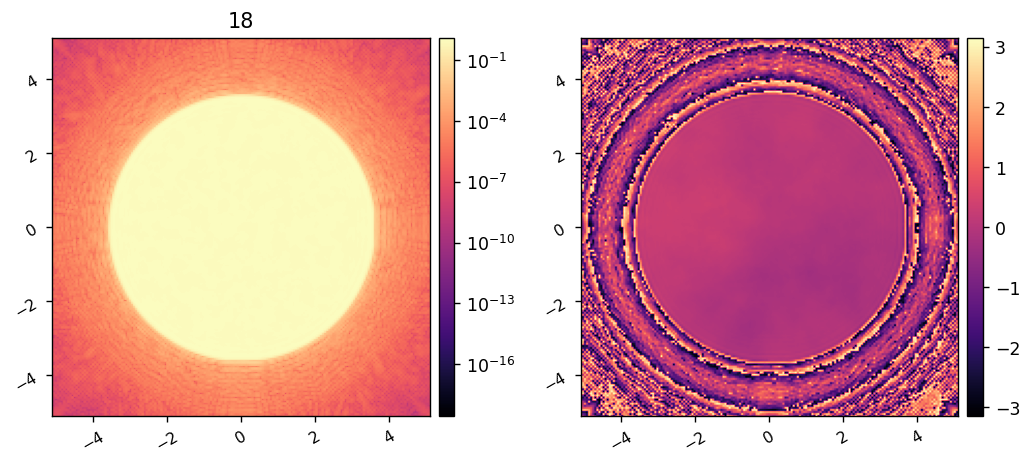

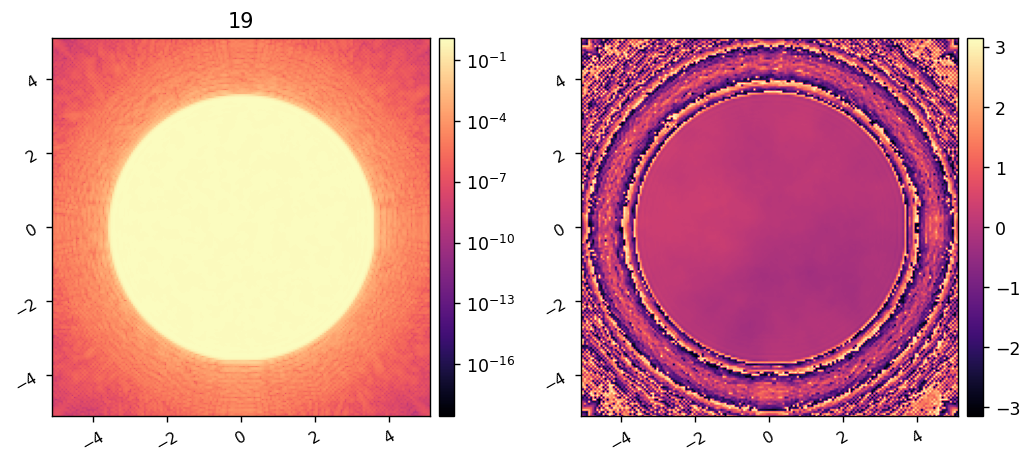

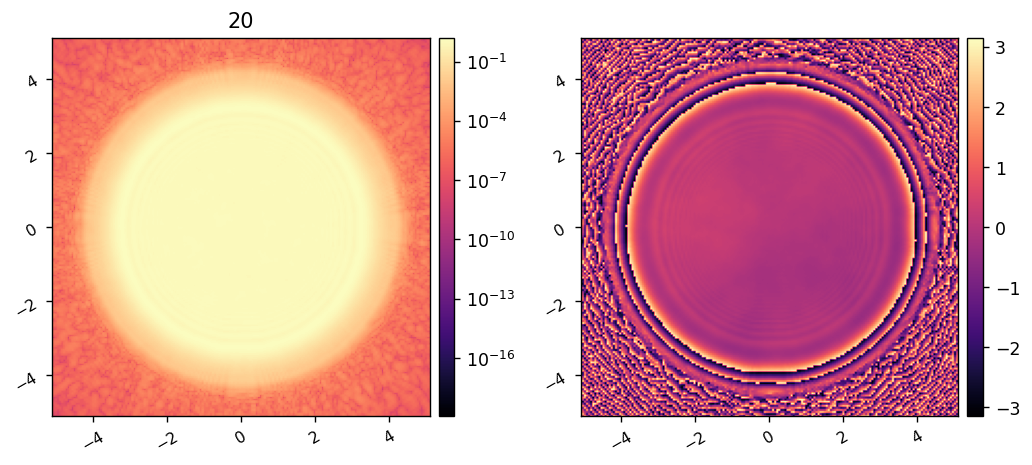

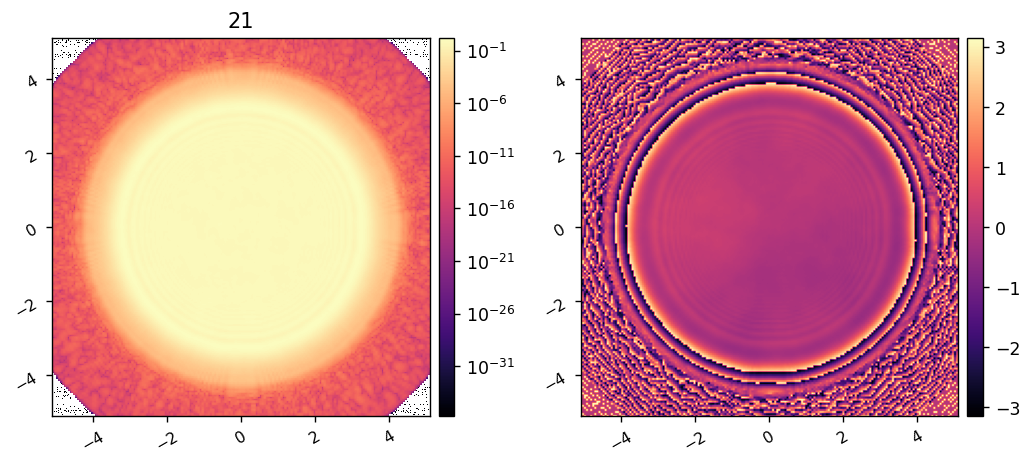

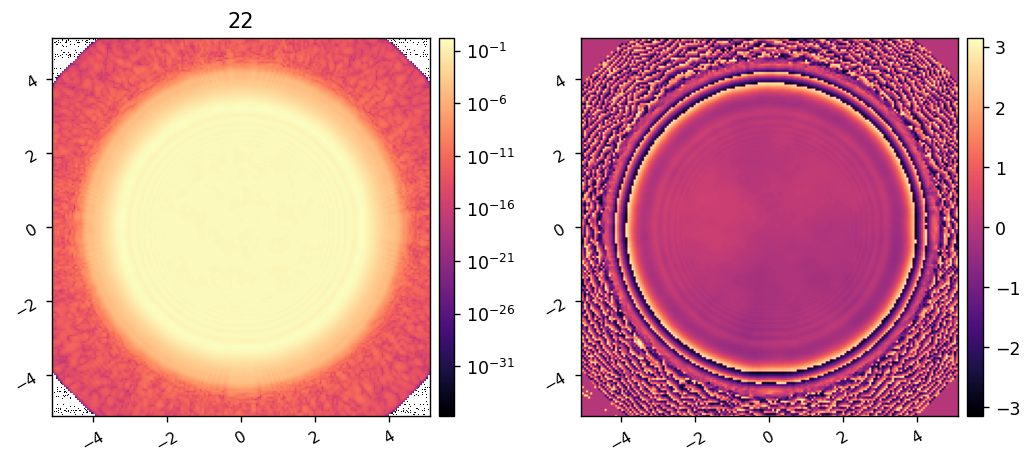

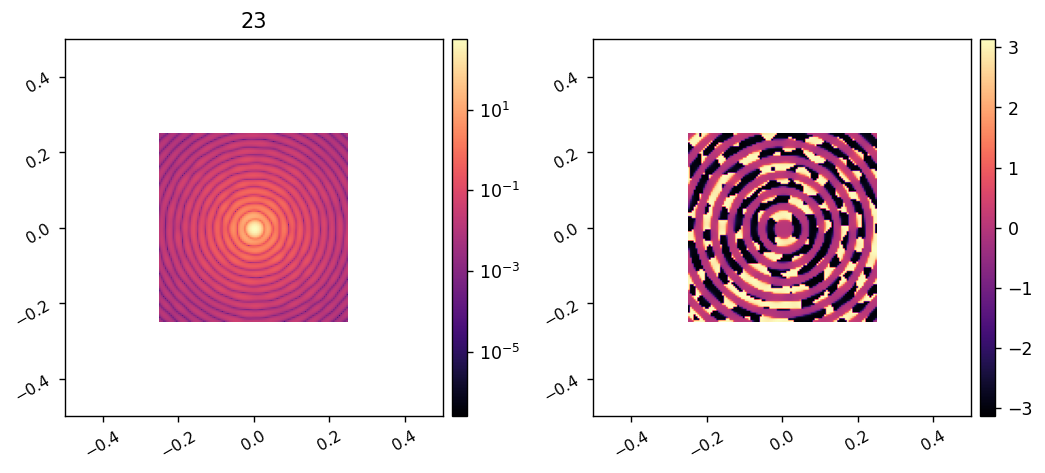

In [9]:
from IPython.display import display

pupil_lim = c.pupil_diam.value/2
fp_lim = 1/2

for i,wf in enumerate(wfs):
    if i-1 in [c.inter_fp_index, c.fpm_index, c.image_index]:
        axlims= [-fp_lim, fp_lim, -fp_lim, fp_lim]
    else:
        axlims= [-pupil_lim, pupil_lim, -pupil_lim, pupil_lim]
    imshow2(wf.intensity, wf.phase, '{:d}'.format(i), 
                 pxscl1=wf.pixelscale.to(u.mm/u.pix), pxscl2=wf.pixelscale.to(u.mm/u.pix),
                 axlims=axlims,
                 lognorm1=True,)

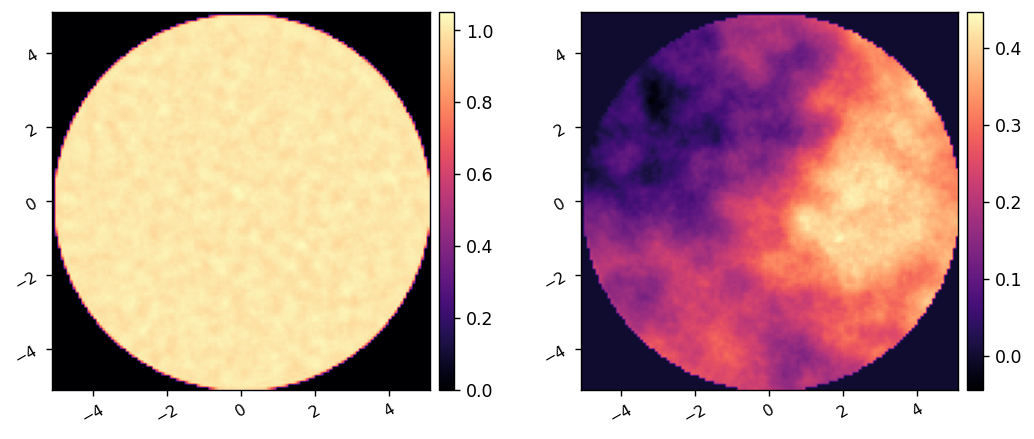

Saved data to:  phase-retrieval-data/pre_fpm_pupil_wfe.fits


In [25]:
pre_fpm_pupil = wfs[10]

x,y = pre_fpm_pupil.coordinates()
r = np.sqrt(x**2 + y**2)
pre_fpm_mask = r<0.0051
imshow2(pre_fpm_pupil.amplitude*pre_fpm_mask, pre_fpm_pupil.phase*pre_fpm_mask,
#              axlims=[-5.1, 5.1, -5.1, 5.1], 
             npix=c.npix,
             pxscl=pre_fpm_pupil.pixelscale.to(u.mm/u.pix))
save_fits('phase-retrieval-data/pre_fpm_pupil_wfe.fits', 
               data=xp.array([poppy.utils.pad_or_crop_to_shape(pre_fpm_pupil.amplitude, (c.npix,c.npix)), 
                              poppy.utils.pad_or_crop_to_shape(pre_fpm_pupil.phase, (c.npix,c.npix))]),
               header={'PIXELSCL':pre_fpm_pupil.pixelscale.value})

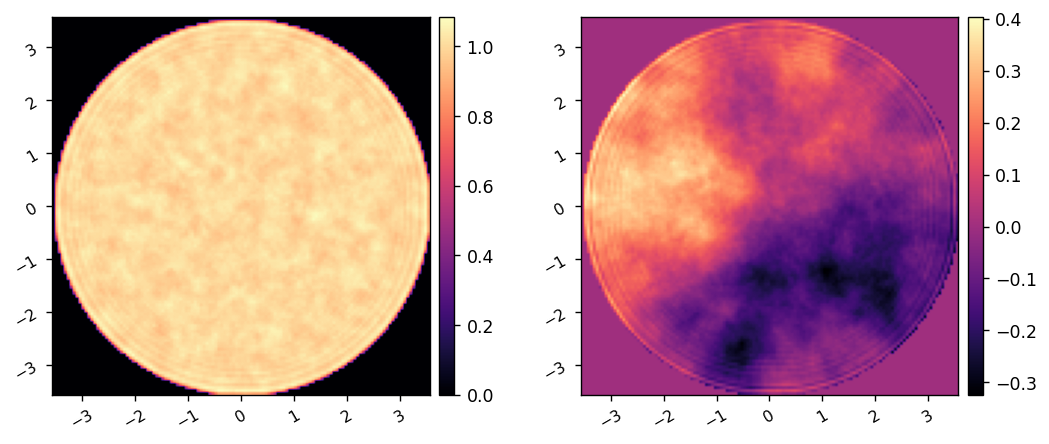

Saved data to:  phase-retrieval-data/post_fpm_pupil_wfe.fits


In [26]:
post_fpm_pupil = wfs[18]
x,y = post_fpm_pupil.coordinates()
r = np.sqrt(x**2 + y**2)
post_fpm_mask = r<(0.0051*350/500)
imshow2(post_fpm_pupil.amplitude*post_fpm_mask, post_fpm_pupil.phase*post_fpm_mask,
#              axlims=[-5.1, 5.1, -5.1, 5.1], 
             npix=c.npix,
             pxscl=post_fpm_pupil.pixelscale.to(u.mm/u.pix))
save_fits('phase-retrieval-data/post_fpm_pupil_wfe.fits', 
               data=xp.array([poppy.utils.pad_or_crop_to_shape(pre_fpm_pupil.amplitude, (c.npix,c.npix)), 
                              poppy.utils.pad_or_crop_to_shape(pre_fpm_pupil.phase, (c.npix,c.npix))]),
               header={'PIXELSCL':post_fpm_pupil.pixelscale.value*500/350})